<center>
    COMP4600/5300 - Reinforcement Learning

# Homework 6 - On-policy Control with Approximation

### Due: Wednesday, November 11th 11:59 pm
    
</center>

Student Name: ______________________ 

The purpose of this project is to study different properties of Function Approximation with on-policy control methods.  

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mountain_car import MountainCar
import pygame as pg
from pygame import gfxdraw

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


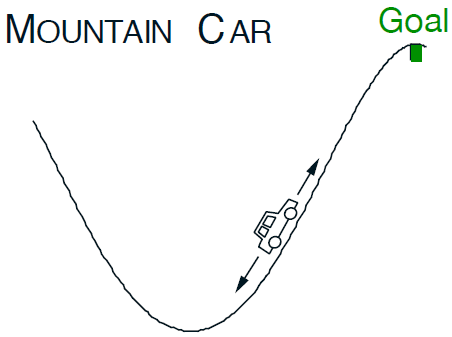


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.


## Part I

You have been given a simple implementation of the Mountain Car task. 

1. Your first task is to check and confirm that the given code simulates the above formulae and task description. Then write a function that generates random episodes for this task. You should use the given code for the Mountain Car task. 


In [2]:
# Your code here
def check_validity():
    xp= -0.6
    vp= 0.0 
    goal_reached=False
    car = MountainCar()
    counter = 0
    while  not goal_reached:
        counter +=1
        xp, vp, r, goal_reached = car.move(xp, vp, 1)
        if counter> 100000:
            print(xp)
            print(vp)
            print(r)
            print(goal_reached)
            print (counter)
            goal_reached = True
check_validity()

-0.5301678215170531
-0.014059804629133643
-1.0
False
100001


In [3]:
def play():
    xp=(np.random.rand()*0.2)-0.6
    vp=0
    goal_reached=False
    car = MountainCar()
    counter = 0
    x=[]
    y=[]
    while  not goal_reached:
        counter +=1
        xp, vp, r, goal_reached = car.move(xp, vp, np.random.choice([-1,0,1]))
        x.append(xp)
        c=0.45*np.sin(3*xp)+0.55
        y.append(c)
        if goal_reached:
            print (counter)
    return x , y
            
xp,yp = play()


79149


2. Use the Pygame library to develop a simple function that animates a given episode/trajectory. The equation for the mountain is $y = 0.45\sin(3x) + 0.55$. Use a randomly generated episode from the function you developed above and pass it to your animation function, then plot the results.

In [4]:
def animation(xp,yp,rate):

    for i in range(len(xp)):
        xp[i]=int(xp[i]*100)+135
        yp[i]=100 - yp[i]*100

    x= np.linspace(-120, 50, 171)
    y=[]
    for i in x:
        c=0.45*np.sin(3*i/100)+0.55
        y.append(int(100-100*c))
    x = np.linspace(15, 185, 171)
    
    pg.init()

    screen_x = 200
    screen_y = 100
    screen = pg.display.set_mode((screen_x, screen_y))
    pg.display.set_caption("mountain car")
    clock = pg.time.Clock()
    screen.fill((0, 0, 0))
    for i in range(len(x)):
        pg.gfxdraw.pixel(screen,int(x[i]),y[i],(255,255,255))
    pg.display.update()

    for k in range(len(xp)):
        clock.tick(rate)

        screen.fill((0, 0, 0))
        for i in range(len(x)):
            pg.gfxdraw.pixel(screen,int(x[i]),y[i],(255,255,255))
        pg.draw.rect(screen, (255,255,0), (xp[k]-5, yp[k]-2, 10, 4))
        pg.display.update()
    pg.quit()

animation(xp,yp,1000)

## Part II

Develop a function approximation procedure based on either **Polynomials** or **Fourier basis** (recommended). Given the current $\bar{w}$, the developed function approximation method should return the value for each specific state.

In [5]:
# Your code here
def scale(s_):
    a=s_[0]
    b=s_[1]
    d=[(a+1.2)*(1/1.7),(b+0.07)*(1/0.14)]
    return d

def fourier_basis(w,s,c):
    state=scale(s)
    k=len(state)
    n=int(np.power(len(w),1/k)-1)
    x_i=[]
    for i in range(int(np.power(n+1,k))):
        angle=0
        for j in range(k):
            angle +=np.pi*state[j]*c[j][i]
        x_i.append(np.cos(angle))
    q=0
    for i in range(int(np.power(n+1,k))):
        q+=w[i]*x_i[i]
    return q , x_i




## Part III

1. Implement the **Episodic Semi-gradient $n$-step SARSA** (pp. 247).

In [6]:
# Your code here
def create_alpha_i_and_c (k,n,alpha):
    c=[[] for j in range(k)]
    alpha_vector=[]
    for i in range(k):
        for j in range(int(np.power(n+1,i))):
            for p in range(n+1):
                for r in range(int(np.power(n+1,k-i-1))):
                    c[i].append(p)
    
    for i in range(int(np.power(n+1,k))):
        sum_=0
        for j in range(k):
            sum_+=np.power(c[j][i],2)
        if sum_==0:
            alpha_vector.append(alpha)
        else:
            alpha_vector.append(alpha/np.sqrt(sum_))
    return alpha_vector , c
        

def Episodic_Semi_gradient_n_step_SARSA(n,alpha,n_order,gamma,epsilon):
    k=2 #number of states
    number_of_actions=3
    w = [[0 for i in range(int(np.power(n_order+1,k)))] for i in range(number_of_actions)]
    act_vector=[-1,0,1]
    alpha_v , c =create_alpha_i_and_c(k,n_order,alpha)# alpha vector and c matrix
    episode=0
    step=[]
    
    while episode!=100:
        episode+=1
        if episode>1:
            epsilon=epsilon*0.1
        car1 = MountainCar()
        t=0
        s=[[0,0]]
        s[0]=[(np.random.rand()*0.2)-0.6,0]#[x,v] initialize
        action=[]
        
        left_value,_=fourier_basis(w[0],s[t],c)
        stop_value,_=fourier_basis(w[1],s[t],c)
        right_value,_=fourier_basis(w[2],s[t],c)
        q_all_action=[left_value,stop_value,right_value]
        if np.random.rand(1)> epsilon:
            max_list_index=np.argwhere(q_all_action == np.amax(q_all_action))
            first_action=act_vector[np.random.choice(max_list_index.flatten().tolist())]
        else:
            first_action=np.random.choice(act_vector)
        action.append(first_action)
        reward=[0]       
        T=np.inf
        loop=True
        check=1
        while loop:
            if t<T:
                next_pos, next_vel, r_next, goal_reached = car1.move(s[t][0], s[t][1], action[t])                
                reward.append(r_next)
                s.append([next_pos,next_vel])

                if goal_reached:
                    T=t+1
                else:
                    next_t=t+1
                    left_value,_=fourier_basis(w[0],s[next_t],c)
                    stop_value,_=fourier_basis(w[1],s[next_t],c)
                    right_value,_=fourier_basis(w[2],s[next_t],c)
                    q_all_action=[left_value,stop_value,right_value]
                    if np.random.rand(1)> epsilon:
                        max_list_index=np.argwhere(q_all_action == np.amax(q_all_action))
                        next_action=act_vector[np.random.choice(max_list_index.flatten().tolist())]

                    else:
                        next_action=np.random.choice(act_vector)
                    action.append(next_action)
            taw=t-n+1
            if taw>=0:
                G=0
                for i in range(taw+1,1+min(taw+n,T)):
                    G+=np.power(gamma,i-taw-1)*reward[i]
                if taw+n <T:
                    q_,_=fourier_basis(w[action[taw+n]+1],s[taw+n],c)#act_value+1 === action index : [-1,0,1]+1===[0,1,2]
                    G+=np.power(gamma,n)*q_
                q,x_i=fourier_basis(w[action[taw]+1],s[taw],c)
                for i in range(len(w[0])):
                    w[action[taw]+1][i]+=alpha_v[i]*(G-q)*x_i[i]
            t+=1
            if taw==T-1:
                loop=False
        step.append(T)
        #print(episode)
    return step , s , w
            


2. Use the algorithm to learn the Mountain Car task with $n \in \{1, 8, 16\}$. Tune the step-size parameter ($\alpha$), select a proper Function Approximation order, discount factor ($\gamma$), exploration probability ($\varepsilon$). Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs.    

In [7]:
# Your code here
steps_1=[]
states_1=[]
w_1=[]
steps_8=[]
states_8=[]
w_8=[]
steps_16=[]
states_16=[]
w_16=[]
for i in range(50):
    step1,states1,w1=Episodic_Semi_gradient_n_step_SARSA(1,0.008,3,1,0.1)
    steps_1.append(step1)
    states_1.append(states1)
    w_1.append(w1)
    
    step8,states8,w8=Episodic_Semi_gradient_n_step_SARSA(8,0.008,3,1,0.1)
    steps_8.append(step8)
    states_8.append(states8)
    w_8.append(w8)
    step16,states16,w16=Episodic_Semi_gradient_n_step_SARSA(16,0.008,3,1,0.1)
    steps_16.append(step16)
    states_16.append(states16)
    w_16.append(w16)

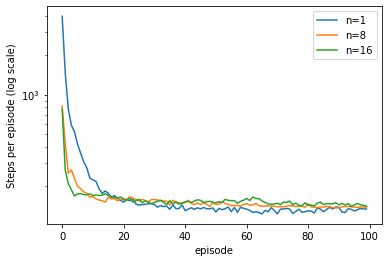

In [10]:
number_of_episodes=100
run_number=50
ave1=[]
ave8=[]
ave16=[]
for i in range(number_of_episodes):
    sum_1=0
    sum_8=0
    sum_16=0
    for j in range(run_number):
        sum_1+=steps_1[j][i]
        sum_8+=steps_8[j][i]
        sum_16+=steps_16[j][i]
    ave1.append(sum_1/run_number)
    ave8.append(sum_8/run_number)
    ave16.append(sum_16/run_number)

plt.plot(ave1,label='n=1')
plt.plot(ave8,label='n=8')
plt.plot(ave16,label='n=16')
plt.xlabel("episode")
plt.ylabel("Steps per episode (log scale)")
plt.yscale("log")
plt.legend()

3. Show an animation of the task for each $n$.

In [13]:
# Your code here
x1=[]
y1=[]
x8=[]
y8=[]
x16=[]
y16=[]
for i in range(len(states1)):
    x1.append(states1[i][0])
    y1.append(0.45*np.sin(3*states1[i][0])+0.55)
for i in range(len(states8)):
    x8.append(states8[i][0])
    y8.append(0.45*np.sin(3*states8[i][0])+0.55)
for i in range(len(states16)):
    x16.append(states16[i][0])
    y16.append(0.45*np.sin(3*states16[i][0])+0.55)

animation(x1,y1,50)
print(len(states1))
animation(x8,y8,50)
print(len(states8))
animation(x16,y16,50)
print(len(states16))


115
136
135


4. Which value of $n$ results in faster learning? Why?
> Answer
As you can see in the plot above,for n=16, 8 and 1 the algorithm finds the optimal pulicy after 5 , 10  and 20 episodes respectively. So n=16 is faster than others. because by increasing n,in each step more w are updated. So the algorithm find the optimal q function faster. 